In [50]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sc
import sklearn as sk
import sklearn.covariance as skc
import graph_helpers as gh

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def remove_diag(M):
    return M - np.diag(np.diag(M))

In [3]:
def confusion_result(P0,P1):
    n,p = P0.shape
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    tol = 1e-3
    for i in range(n):
        for j in range(i):
            if abs(P0[i,j])>tol and abs(P1[i,j])>tol:  #les 2 ont une arete
                TP +=1
            elif abs(P0[i,j])<tol and abs(P1[i,j])<tol:  #les 2 n'ont pas d'arete
                TN +=1
            elif abs(P0[i,j])<tol and abs(P1[i,j])>tol:  # arete trouvée dans P1 mais pas dasn P0
                FP +=1
            else:
                FN +=1  #arete presente dans P0 mais dasn P1
    return(TP, FP, TN, FN)

In [58]:
def score(nom, P0, P1):
    TP, FP, TN, FN = confusion_result(P0,P1) 
    
    if nom == 'L1':  #norme L1
        num_vertices = P0.shape[0]
        return np.linalg.norm(P0-P1,1)/num_vertices**2
    
    elif nom == 'L0':  #norme L1
        #sc_l0 = (FP+FN)/num_vertices**2
        nb_edge = np.sum( remove_diag(P0).flatten()!=0 ) # nombre d'arretes dans P0
        return 2*(FP+FN)/nb_edge
    
    elif nom == 'F1':
        return TP/(TP+0.5*(FP+FN))

# graphical lasso

On considère $n$ observations $x_{1},x_{2},\ldots ,x_{n}$. On s'interesse à l'estimation d'une matrice de précision $P_0 = C_0^{-1}$. Si on fait l'hypothèse que les $x_i$ sont tirés aléatoirement suivant un va gaussienne $Z  \sim \mathcal{N}(0,C_0)$, on espère que le $C_1= P_1^{-1}$ obtenu est une bonne estimation de la matrice de covariance $C_0$ de $Z$. 

Le graphical lasso résout
$$\operatorname {argmin} _{P \geq 0} \operatorname {tr} (C P )-\log \det(P )+\lambda \sum _{j\neq k}|P _{jk}|$$

où $C$ est la covariance des échantillons, et $\lambda$ est le paramètre de pénalisation.

Nous allons tester le graphical lasso sur les différentes formes de graphes synthétisés afin d'évaluer ses performances.

In [4]:
# on définit un graphe par sa matrice de précision
num_vertices = 49
a = .8  # corrélation minimum 
name = "ligne"
name = "cyclique"
name = "kvoisin"
name = "grilleCarree" #cyclique ou grilleCarree ou kvoisin
A,Vx,Vy = gh.init_graph(name,num_vertices)

U = np.triu((1-a)*np.random.rand(num_vertices,num_vertices) + a)  # bruit balnc entre a et 1 
U=U+U.T    # Pour que Q soit symétrique
Q = A*U    # matrice de graphe pondéré
assert np.linalg.norm(Q-Q.T)<1e-6, "Q n'est pas symétrique !"

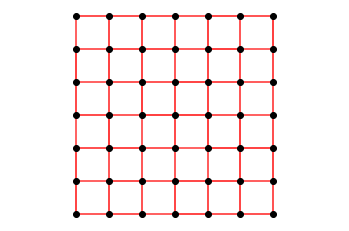

In [5]:
gh.dessin_graphe(Q,Vx,Vy)

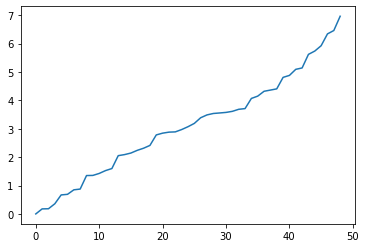

In [6]:
L = np.diag(np.sum(Q, axis = 0)) - Q
plt.plot(np.sort(np.linalg.eigvals(L)))

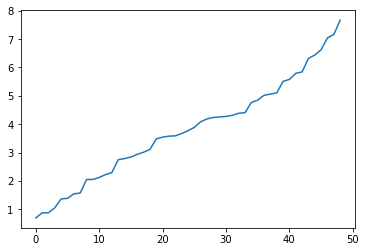

In [7]:
#Pour générer des vecteurs gaussiens de matrice l'inverse de L, L doit être inversible, 
#ce qui n'est pas forcément le cas. On modifie L pour avoir des vp positives
# c est un paramètre qui permet de jouer sur le conditionnement de la matrice de précision

c = 0.1   #10% de la vp maximale est ajoutée à la diagonale
E = np.linalg.eigvals(L)
sigma = c*np.max(E)
P0 = L + sigma*np.eye(num_vertices) 

plt.plot(np.sort(np.linalg.eigvals(P0)))

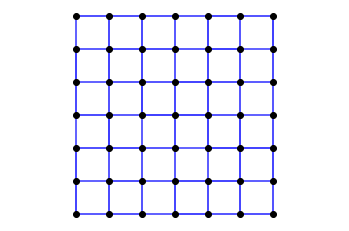

In [8]:
gh.dessin_graphe(P0,Vx,Vy)

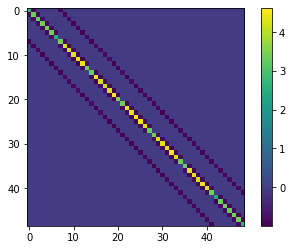

In [9]:
plt.imshow(P0)
plt.colorbar()

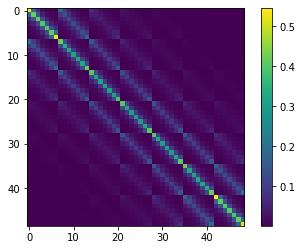

In [10]:
C0 = np.linalg.inv(P0)
plt.imshow(C0)
plt.colorbar()

Pour générer des vecteurs gaussiens de matrice de covariance $C_0$ : 

`w = randn(num_vertices,1)` réalisation d'un vecteur gaussien de moyenne nulle et de covariance $I_{m\times m}$ (soit $E(ww^T) = I_{m\times m}$ ($m=$`num_vertices`)

Soit $A$ matrice telle que $Z = Aw$. On a alors  Cov($Z$) = $E(ZZ^T) = E(Aw(Aw)^T) = A E(ww^T)A^T = AA^T$. Pour générer des vecteurs gaussiens de matrice de covariance $C_0$ soit $AA^T$, on peut choisir $A = C_0^{\frac{1}{2}}$ car $C_0$ positive.

In [11]:
n = 1000 # nombre d'échantillons
# on génére des va gaussiens de moyenne nulle et de matrice de covariance C0
X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,n)).T
#covariance empirique des échantillons
C = X.T@X/n

Dessine un signal généré.

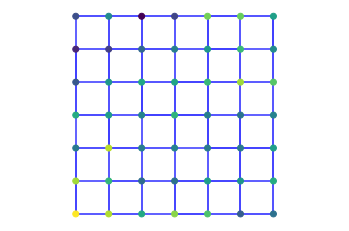

In [12]:
gh.dessin_graphe(P0,Vx,Vy,X[0,:])

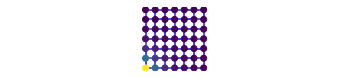

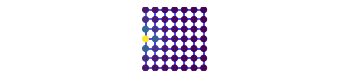

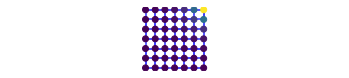

In [13]:
plt.subplot(3,1,1)
gh.dessin_graphe(P0,Vx,Vy,C0[0,:])
plt.subplot(3,1,2)
gh.dessin_graphe(P0,Vx,Vy,C0[num_vertices//2-3,:])
plt.subplot(3,1,3)
gh.dessin_graphe(P0,Vx,Vy,C0[-1,:])

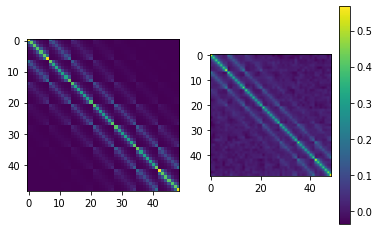

In [14]:
plt.subplot(1,2,1)
plt.imshow(C0)
plt.subplot(1,2,2)
plt.imshow(C)
plt.colorbar()

In [15]:
lamda = 0.1
C1,P1 = skc.graphical_lasso(C,lamda)

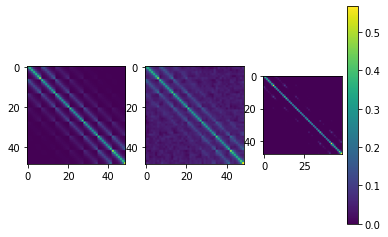

In [16]:
plt.subplot(1,3,1)
plt.imshow(C0)
plt.subplot(1,3,2)
plt.imshow(C)
plt.subplot(1,3,3)
plt.imshow(C1)
plt.colorbar()

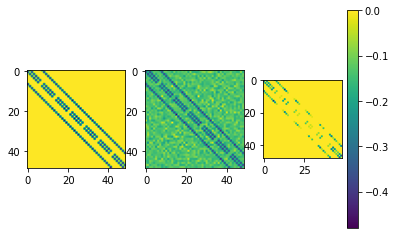

In [17]:
plt.subplot(1,3,1)
plt.imshow(remove_diag(P0))
plt.subplot(1,3,2)
plt.imshow(remove_diag(np.linalg.inv(C)))
plt.subplot(1,3,3)
plt.imshow(remove_diag(P1))
plt.colorbar()

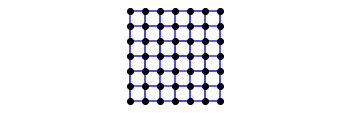

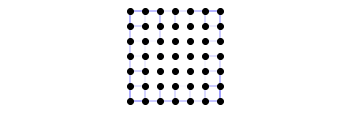

In [18]:
plt.subplot(2,1,1)
gh.dessin_graphe(P0,Vx,Vy)
plt.subplot(2,1,2)
gh.dessin_graphe(P1,Vx,Vy)

In [523]:
P0 = np.array([[1,1,1],[1,0,0],[1,0,1]])
P1 = np.array([[1,0,1],[0,0,0],[1,0,1]])
print(confusion_result(P0,P1))

(1, 0, 1, 1)


# comparaison avec méthode du TP6 : seuillage des éléments de la matrice de corrélation plutot que graphical lasso

In [458]:
correlation_threshold = 0.2
C2 = np.where(C > correlation_threshold, C, 0.0)

In [459]:
scoreL1 = np.linalg.norm(P0-C2,1)/n**2
print("scoreL1 = ",scoreL1)

TP, FP, TN, FN = confusion_result(P0,C2) 
scoreL0 = (FP+FN)/num_vertices**2
print("scoreL0 = ",scoreL0)

scoreL1 =  6.353451207298906e-06
scoreL0 =  0.0212411495210329


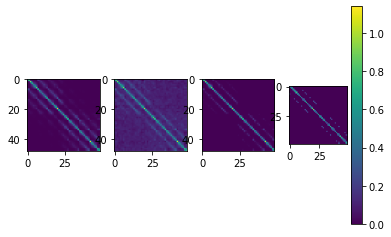

In [349]:
plt.subplot(1,4,1)
plt.imshow(C0)
plt.subplot(1,4,2)
plt.imshow(C)
plt.subplot(1,4,3)
plt.imshow(C1)
plt.subplot(1,4,4)
plt.imshow(C2)
plt.colorbar()

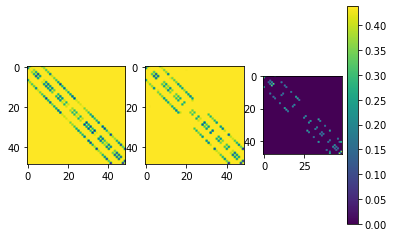

In [350]:
def remove_diag(M):
    return M - np.diag(np.diag(M))
plt.subplot(1,3,1)
plt.imshow(remove_diag(P0))
plt.subplot(1,3,2)
plt.imshow(remove_diag(P1))
plt.subplot(1,3,3)
plt.imshow(remove_diag(C2))
plt.colorbar()

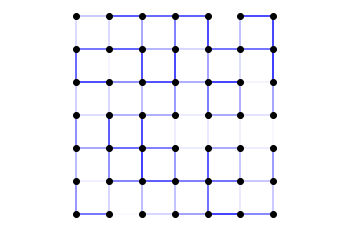

In [351]:
gh.dessin_graphe(P0,Vx,Vy)

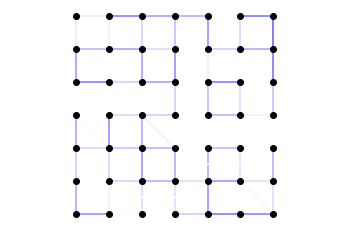

In [352]:
gh.dessin_graphe(P1,Vx,Vy)

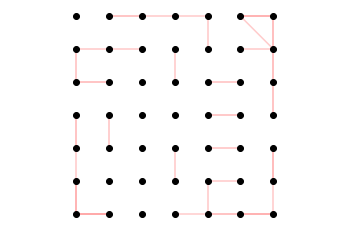

In [353]:
gh.dessin_graphe(C2,Vx,Vy)

# seuillage des éléments de la "presque" matrice de précision 

scoreL1 =  0.0014782281647478298
scoreL0 =  0.037067888379841735


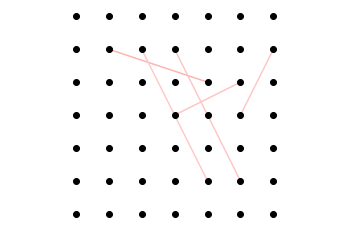

In [460]:
eps =1e-7
P3 = np.linalg.inv(C + eps*np.eye(num_vertices))  # car pb de non inversabilité de la matrice de corrélation C

t = 0.2
P3 = np.where(P3 > t, P3, 0.0)

scoreL1 = np.linalg.norm(P0-P3,1)/num_vertices**2
print("scoreL1 = ",scoreL1)

TP, FP, TN, FN = confusion_result(P0,P3) 
scoreL0 = (FP+FN)/num_vertices**2
print("scoreL0 = ",scoreL0)

gh.dessin_graphe(P3,Vx,Vy)

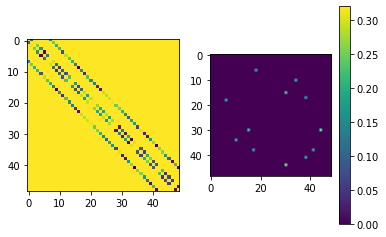

In [355]:
plt.subplot(1,2,1)
plt.imshow(remove_diag(P0))
plt.subplot(1,2,2)
plt.imshow(remove_diag(P3))
plt.colorbar()

# m et n fixé, trouver meilleur lambda

# m fixé, trouver pour quel n on retrouve le graphe

In [45]:
def gen_precision(nom_graphe,num_vertices,correlation_min=.9,c=.5):
    """génération d'une matrice de précision"""
    A,Vx,Vy = gh.init_graph(nom_graphe,num_vertices)
    U = np.triu((1-correlation_min)*np.random.rand(num_vertices,num_vertices) + correlation_min)       
    Q = A*(U+U.T)     #matrice graphe pondéré
    L = np.diag(np.sum(Q, axis = 0)) - Q
    sigma = c*np.max(np.linalg.eigvals(L))
    P0 = L + sigma*np.eye(num_vertices) 
    return P0

In [46]:
def set_lambda_max(C0):
    """ dans graphical lasso, recherche lamda_max (si lamda est trop grand, graphe sans arete)"""
    lamda = 100
    u = 0
    it = 0
    while u<1e-3 and it<50:
        C1,P1 = skc.graphical_lasso(C0,lamda)
        u = np.linalg.norm(remove_diag(P1))
        it = it+1
        lamda = lamda*.8
    assert it!=50, "probleme dans la recherche de lambda_max"
    return lamda/.8

In [51]:
def repport_performance(P0,num_samples,nrep=10,nlambda=30,lmax=-1,type_score='L0'):
    num_vertices = P0.shape[0]
    C0 = np.linalg.inv(P0)
    X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,num_samples)).T
    C = X.T@X/num_samples   
    if lmax<0:
        lmax = set_lambda_max(C)
    lmin = lmax/1000
    list_score = []
    lambda_list = list(np.linspace(lmin,lmax,nlambda))
    for i in range(nrep):
        X = (sc.linalg.sqrtm(C0)@np.random.randn(num_vertices,num_samples)).T
        C = X.T@X/num_samples
        score_l = []
        for lamda in lambda_list:
            C1,P1 = skc.graphical_lasso(C,lamda)
            score_l.append(score(type_score, P0, P1))                 
        list_score.append(score_l)
    M = np.mean(list_score, axis=0)  
    S = np.std(list_score, axis=0) 
    return lambda_list, M, S

In [74]:
 def plot_lambda_influ(nom_graphe,correlation_min,num_vertices,c,num_samples,nlambda=30,type_score='L0',lmin=-1,lmax=-1,nrep=30,nom_figure=''):
        """trace score en fonction de lambda"""
        P0 = gen_precision(nom_graphe,num_vertices,correlation_min,c)
        lambda_list, M, S = repport_performance(P0,num_samples,nrep,nlambda,lmax,type_score)
        plt.plot(lambda_list,M)
        plt.fill_between(lambda_list,M-S, M+S ,alpha=0.3)        
        plt.title("Graphe {0}, correlation_min = {1}, m = {2}, c = {3}, n = {4}".format(nom_graphe,correlation_min,num_vertices,c,num_samples))
        plt.xlabel("lambda")
        plt.ylabel("score {0}".format(type_score))
        if nom_figure!='':
            plt.savefig(nom_figure)   

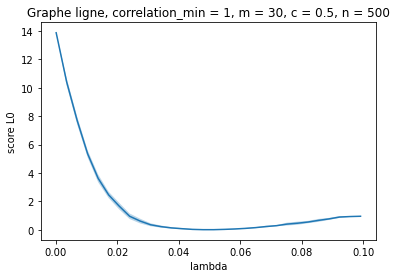

In [94]:
nom_graphe = "ligne"
num_vertices = 30
correlation_min = 1
c = .5
num_samples = 500
plot_lambda_influ(nom_graphe,correlation_min,num_vertices,c,num_samples,type_score='L0',nrep=5)

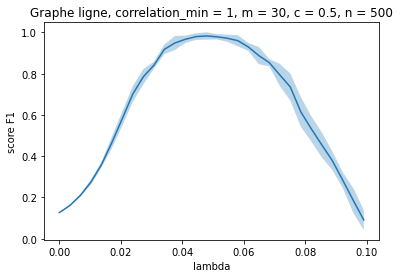

In [89]:
plot_lambda_influ(nom_graphe,correlation_min,num_vertices,c,num_samples,nrep=5, type_score='F1')

In [95]:
nbr_N = 6
N_list =  np.linspace(50,500,nbr_N).astype(int)
nlambda = 20
nrep = 8
P0 = gen_precision(nom_graphe,num_vertices,correlation_min,c)
score_list = np.zeros(nbr_N)
std_list = np.zeros(nbr_N)
for j in range(len(N_list)):
    num_samples = N_list[j]
    lambda_list, M, S = repport_performance(P0,num_samples,nrep,nlambda)
    score_list[j] = np.min(M)
    std_list[j] = S[ np.argmin(M) ]

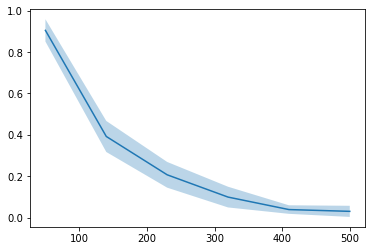

In [96]:
plt.plot(N_list,score_list)
plt.fill_between(N_list,score_list-std_list, score_list+std_list,alpha=0.3)   

# A faire

* tests sur tous les types de graphes

* graphical lasso avec cvxpt, rajouter contraintes Laplacien + article Dong (slides AST6 - 76 et 77)
